In [89]:
# imports
from MCForecastTools import MCSimulation
from time import sleep
import math
import requests
import json
import panel as pn
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from dotenv import load_dotenv
from pandas import json_normalize
from twilio.rest import Client
    
import warnings
warnings.filterwarnings('ignore')

In [67]:
# Set up Panel Plotly extension
pn.extension('plotly')

In [68]:
# Import hvplot.pandas after pn.extension
# This avoids plotly initialization failure
import hvplot.pandas

In [69]:
# Define path to datasets
dow_jones_list_path = Path('../data/rawdata/dow_jones_list.json')
sp_500_list_path = Path('../data/rawdata/sp_500_list.json')
nasdaq_100_list_path = Path('../data/rawdata/nasdaq_100_list.json')

In [70]:
# Base URL for fmp
fmp_base_url = 'https://financialmodelingprep.com/api/v3/'

In [90]:
# Read in API keys
load_dotenv('./billy/api_keys.env')
fmp_api = os.getenv("FMP_API_KEY")
account_sid = os.environ['TWILIO_SID']
auth_token = os.environ['TWILIO_AUTH_TOKEN']

In [92]:
# Connect to Twilio
client = Client(account_sid, auth_token)

In [97]:
message = client.messages \
                .create(
                     body="Hello from Python",
                     from_='+19032877979',
                     to='+13057257577'
                 )

print(message.sid)

SM10ee689e3adf40b5a13265f9a4db39c8


In [72]:
# Read in datasets
dow_jones_list = pd.read_json (dow_jones_list_path)
sp_500_list = pd.read_json (sp_500_list_path)
nasdaq_100_list = pd.read_json (nasdaq_100_list_path)

# Add MarketCap Column
dow_jones_list['marketcap'] = 0
sp_500_list['marketcap'] = 0
nasdaq_100_list['marketcap'] = 0

## Variable Definitions

In [73]:
# Column Management
profile_column_names = ['symbol','price','beta','volAvg','mktCap','lastDiv','range','changes','companyName','currency','cik','isin','cusip',
                'exchange','exchangeShortName','industry','website','description','ceo','sector','country','fullTimeEmployees',
                'phone','address','city','state','zip','dcfDiff','dcf','image','ipoDate','defaultImage','isEtf','isActivelyTrading']

quote_column_names = ['symbol','name','price','changesPercentage','change','dayLow','dayHigh','yearHigh','yearLow','marketCap','priceAvg50',
                      'priceAvg200','volume','avgVolume','exchange','open','previousClose','eps','pe','earningsAnnouncement',
                      'sharesOutstanding','timestamp']

rating_column_names = ['symbol','ratingdate','rating','ratingScore','ratingRecommendation','ratingDetailsDCFScore','ratingDetailsDCFRecommendation',
                       'ratingDetailsROEScore','ratingDetailsROERecommendation','ratingDetailsROAScore','ratingDetailsROARecommendation',
                       'ratingDetailsDEScore','ratingDetailsDERecommendation','ratingDetailsPEScore','ratingDetailsPERecommendation',
                       'ratingDetailsPBScore','ratingDetailsPBRecommendation']

column_names = ['symbol','beta','volAvg','mktCap','lastDiv','range','changes','companyName','currency','cik','isin','cusip',
                'exchange','exchangeShortName','industry','website','description','ceo','sector','country','fullTimeEmployees',
                'phone','address','city','state','zip','dcfDiff','dcf','image','ipoDate','defaultImage','isEtf','isActivelyTrading',
                'price','changesPercentage','change','dayLow','dayHigh','yearHigh','yearLow','marketCap','priceAvg50','priceAvg200',
                'volume','avgVolume','exchange','open','previousClose','eps','pe','earningsAnnouncement','sharesOutstanding','timestamp',
                'held','totalheld','ratingdate','rating','ratingScore','ratingRecommendation','ratingDetailsDCFScore',
                'ratingDetailsDCFRecommendation','ratingDetailsROEScore','ratingDetailsROERecommendation','ratingDetailsROAScore',
                'ratingDetailsROARecommendation','ratingDetailsDEScore','ratingDetailsDERecommendation','ratingDetailsPEScore',
                'ratingDetailsPERecommendation','ratingDetailsPBScore','ratingDetailsPBRecommendation']

rating_names= ['symbol','companyName','exchangeShortName','industry','sector','dayLow','dayHigh','yearHigh','yearLow','priceAvg50','priceAvg200',
               'eps','pe','sharesOutstanding','held','totalheld','ratingdate','rating','ratingScore','ratingDetailsDCFScore','ratingDetailsROEScore',
               'ratingDetailsROAScore','ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']

In [74]:
# Portfolio Holdings
jorge_holdings = {'AMZN':1,'BA':14,'BABA':10,'DAC':20,'FLGT':141,'PYPL':16}

william_holdings = {'T': 70,'LI': 20,'LNC': 10,'ONTO': 10,'UWMC': 100,'ABBV': 10,'ALL': 10,'GOLD': 100,'BEAM': 10,'BNGO': 70,
                    'CTXS': 10,'NIO': 40,'NVS': 11,'PCAR': 10,'PLTR': 36,'PYPL': 4,'PENN': 8,'PWOD': 45,'RPTX': 10,'RKT': 25,
                    'TER': 8,'VZ': 40}

# Removed from list 'CCIV': 145,'GNOG': 220, 'RBLX': 10,'SGFY': 50,

juancarlos_holdings = {'ZM':150,'MSFT':150,'SQ':150,'BABA':150,'AAPL':150,'TSLA':150,'COST':150,'T':150,'FB':150,'DIS':150,'UBER':150,'JPM':150,'TSN':150,'QCOM':150,'ALLY':150}

In [75]:
# Name to convert big numbers to human readable
millnames = ['',' Thousand',' Million',' Billion',' Trillion']

## Functions

In [76]:
def get_btcusdt_price():
    # Crypto API URLs
    btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
    eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

    # Fetch current BTC price
    btc_response = requests.get(btc_url)
    btc_data = btc_response.json()
    btc_price = btc_data['data']['1']['quotes']['USD']['price']
    return btc_price

In [77]:
def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

In [78]:
def append_market_cap(dataset):
    df_marketcap = pd.DataFrame()
    count = 0
    for symbol in dataset['symbol']:
        # Query company info from api
        fmp_profile = (f'market-capitalization/{symbol}?apikey={fmp_api}')
        fmp_profile_response = requests.get(fmp_base_url + fmp_profile)
        data = fmp_profile_response.json()
        marketcap = data[0]['marketCap']
        dataset['marketcap'][count] = marketcap
        count += 1
        sleep(0.05)
        
    return dataset


def market_movers():
    mover_column_names = ['date','TotalScore','ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore',
                          'ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']
    score_column_names = ['ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore',
                          'ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']
    fmp_gainers = (f'gainers?apikey={fmp_api}')
    fmp_losers = (f'losers?apikey={fmp_api}')
    # request data from api provider
    fmp_gainers_response = requests.get(fmp_base_url + fmp_gainers)
    fmp_losers_response = requests.get(fmp_base_url + fmp_losers)
    # Store response
    gainers_data = fmp_gainers_response.json()
    losers_data = fmp_losers_response.json()
    # Create dataframes
    output = pd.DataFrame()
    df_gainers = pd.DataFrame(gainers_data)
    df_losers = pd.DataFrame(losers_data)
    df_movers = pd.concat([df_gainers,df_losers],ignore_index=True)
    df_movers = pd.concat([df_movers,pd.DataFrame(columns = mover_column_names)])
    count = 0
    # Iterate through gainer positions
    for ticker in list(df_movers['ticker']):
        sum = 0
        # build url
        fmp_rating = (f'rating/{ticker}?apikey={fmp_api}')
        # request data from api provider
        fmp_rating_response = requests.get(fmp_base_url + fmp_rating)
        # Store response
        if str(fmp_rating_response.json())[1:-1] == '':
            count += 1
            continue
        else:
            rating_data = fmp_rating_response.json()[0]
            df_movers['price'] = df_movers['price'].astype(float)
            df_movers['changes'] = df_movers['changes'].astype(float)
            df_movers['changesPercentage'][count] = df_movers['changes'][count] / (df_movers['price'][count] - df_movers['changes'][count])
            for col in mover_column_names:
                if col == 'TotalScore':
                    for col2 in score_column_names:
                        sum += rating_data.get(col2)
                    df_movers[col][count] = sum
                else:
                    df_movers[col][count] = rating_data.get(col)
            count += 1
            
    # Clean up dataframe
    df_movers.dropna(inplace=True)
    df_movers.reset_index(inplace=True)
    df_movers.drop(['index'], axis=1, inplace=True)
    df_movers.rename(columns = {'companyName':'Name','rating':'Rating','ratingScore':'Score','ratingDetailsDCFScore':'DCF',
                                'ratingDetailsROEScore':'ROE','ratingDetailsROAScore':'ROA','ratingDetailsDEScore':'DE',
                                'ratingDetailsPEScore':'PE','ratingDetailsPBScore':'PB','changesPercentage':'Percentage'}, inplace=True)
    
    long_ideas = df_movers[['ticker','Name','price','changes','Percentage']][(df_movers['TotalScore']>23) & (df_movers['Percentage']<0)]
    short_ideas = df_movers[['ticker','Name','price','changes','Percentage']][(df_movers['TotalScore']<17) & (df_movers['Percentage']>0)]
    
    return long_ideas, short_ideas

def portfolio_gather_data(dataset):
    final_df = pd.DataFrame(columns = column_names)
    to_append = []

    # Iterate through positions
    for ticker in list(dataset.keys()): 
        # build url
        fmp_profile = (f'profile/{ticker}?apikey={fmp_api}')
        fmp_quote = (f'quote/{ticker}?apikey={fmp_api}')
        fmp_rating = (f'rating/{ticker}?apikey={fmp_api}')
        # request data from api provider
        fmp_profile_response = requests.get(fmp_base_url + fmp_profile)
        fmp_quote_response = requests.get(fmp_base_url + fmp_quote)
        fmp_rating_response = requests.get(fmp_base_url + fmp_rating)
        # Store response
        profile_data = fmp_profile_response.json()[0]
        quote_data = fmp_quote_response.json()[0]
        rating_data = fmp_rating_response.json()[0]
        
        # prepare profile dataframe
        profile_columns = profile_data.keys()
        to_append_profile = [profile_data[column] for column in profile_columns]
        to_append_profile.pop(1)
        
        # prepare quote dataframe
        quote_columns = quote_data.keys()
        to_append_quote = [quote_data[column] for column in quote_columns]
        to_append_quote.pop(0)
        to_append_quote.pop(0)
        
        # preapare rating dataframe
        rating_columns = rating_data.keys()
        to_append_rating = [rating_data[column] for column in rating_columns]
        to_append_rating.pop(0)
        
        # Create list
        to_append_calculations = [dataset.get(ticker), dataset.get(ticker)*to_append_quote[0]]
        
        # Concat all fields
        to_append = to_append_profile + to_append_quote + to_append_calculations + to_append_rating
        
        df_length = len(final_df)
        final_df.loc[df_length] = to_append          
        
    return final_df

## Visualization Functions

In [79]:
def index_sector_plot(dataset, title):
    pie_plot = px.pie(
        dataset,
        values='marketcap',
        names='sector',
        title=title,
        width=500,
        hover_data={
        #"marketcap": millify(dataset['marketcap']),
        }
    )
    
    return pie_plot

def portfolio_sector_plot(dataset, title):
    pie_plot = px.pie(
        dataset,
        values='totalheld',
        names='sector',
        title=title,
        width=500,
        hover_data={
        #"marketcap": millify(dataset['marketcap']),
        }
    )
    
    return pie_plot

def portfolio_ratings_plot(dataset):
    rating_view = ['companyName','rating','ratingScore','ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore',
                   'ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']
    
    df_rating = dataset[rating_view]
    
    df_rating.rename(columns = {'companyName':'Name','rating':'Rating','ratingScore':'Score','ratingDetailsDCFScore':'DCF',
                                'ratingDetailsROEScore':'ROE','ratingDetailsROAScore':'ROA','ratingDetailsDEScore':'DE',
                                'ratingDetailsPEScore':'PE','ratingDetailsPBScore':'PB'}, inplace=True)
    
    # Add our Total Score value and drop original data Score
    sum_column = df_rating['DCF']+df_rating['ROE']+df_rating['ROA']+df_rating['DE']+df_rating['PE']+df_rating['PB']
    df_rating['Total Score'] = sum_column
    df_rating.drop(['Score'], axis=1)
    
    # Rearrange columns as per Juan Carlos
    df_rating = df_rating[['Name','Rating','Total Score','DCF','ROE','ROA','DE','PE','PB']]
    
    return df_rating

# JCs Distribution plot
def portfolio_distribution_plot(dataset):
    pie_plot = dataset.set_index('symbol').plot.pie(y='totalheld',
                                                    figsize=(12,12),
                                                    startangle=0,
                                                    autopct='%1.1f%%',
                                                    legend=False).figure
    return pie_plot

# Bitcoin Plots
def bitcoin_simulation_plot():
    # Plot simulation outcomes
    line_plot = MC_72_hours.plot_simulation()

    # Save the plot for future usage
    line_plot.get_figure().savefig('../images/MC_Bitcoin_72_hours_sim_plot.png', bbox_inches="tight")
    
    fig, ax = plt.subplots()  
    
    return plt.figure()

def bitcoin_distribution_plot():
    # Plot probability distribution and confidence intervals
    dist_plot = MC_72_hours.plot_distribution()

    # Save the plot for future usage
    dist_plot.get_figure().savefig('../images/MC_Bitcoin_72_hours_dist_plot.png',bbox_inches='tight')
    
    fig, ax1 = plt.subplots()  
    
    return plt.figure()

## Other

In [80]:
df_jorge_holdings = portfolio_gather_data(jorge_holdings)
df_william_holdings = portfolio_gather_data(william_holdings)
df_juancarlos_holdings = portfolio_gather_data(juancarlos_holdings)

In [81]:
dow_jones_list = append_market_cap(dow_jones_list)
dow_jones_list.to_csv('../data/cleandata/dow_jones_list.csv', index=False)

In [82]:
nasdaq_100_list = append_market_cap(nasdaq_100_list)
nasdaq_100_list.to_csv('../data/cleandata/nasdaq_100_list.csv', index=False)

In [83]:
sp_500_list = append_market_cap(sp_500_list)
sp_500_list.to_csv('../data/cleandata/sp_500_list.csv', index=False)

## Dashboard

In [84]:
dow_jones_marketcap = millify(dow_jones_list['marketcap'].sum())
nasdaq_100_marketcap = millify(nasdaq_100_list['marketcap'].sum())
sp_500_marketcap = millify(sp_500_list['marketcap'].sum())
jorge_total = millify(df_jorge_holdings['totalheld'].sum())
william_total = millify(df_william_holdings['totalheld'].sum())
juancarlos_total = millify(df_juancarlos_holdings['totalheld'].sum())

In [85]:
# Find the ideas for screener tab
long_ideas, short_ideas = market_movers()

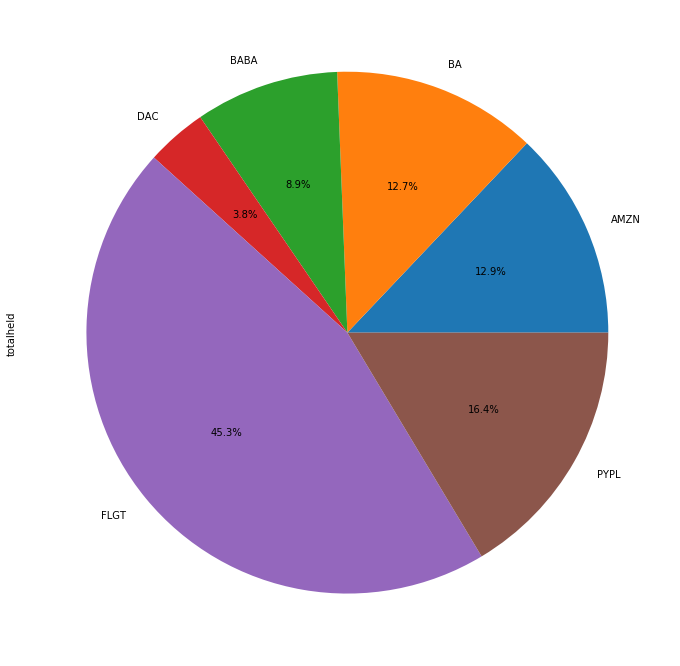

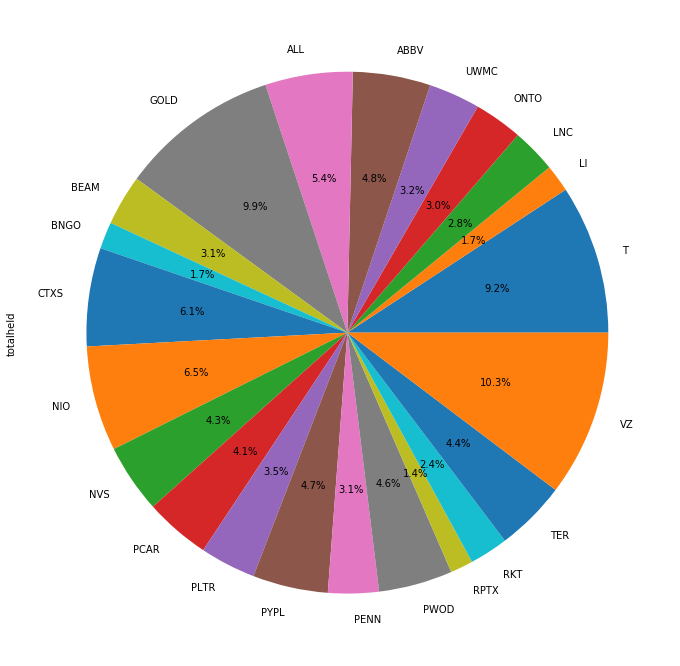

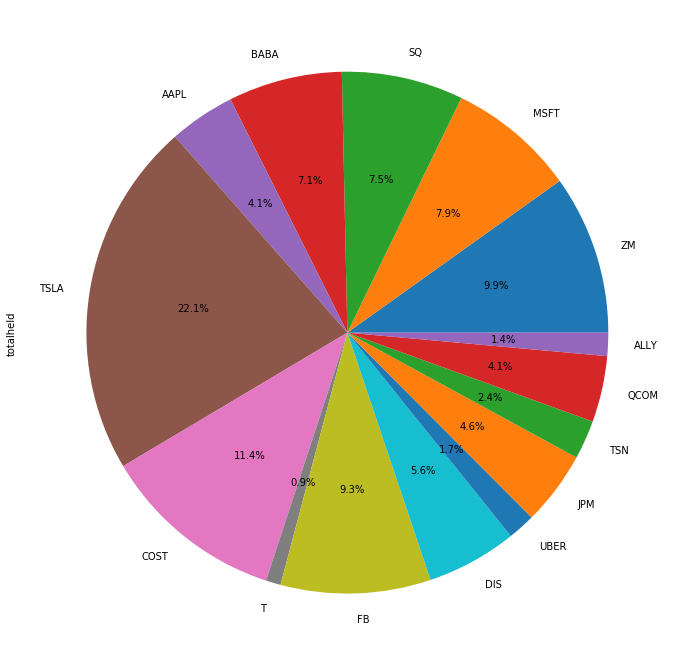

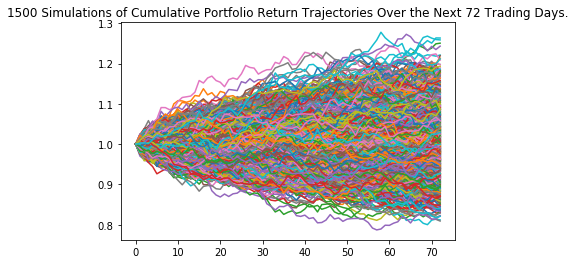

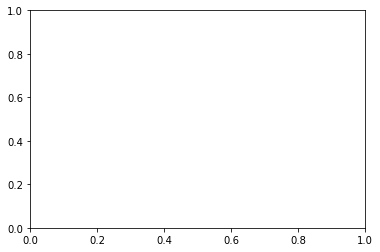

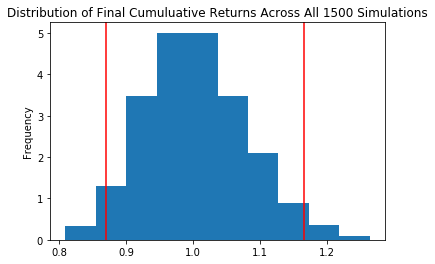

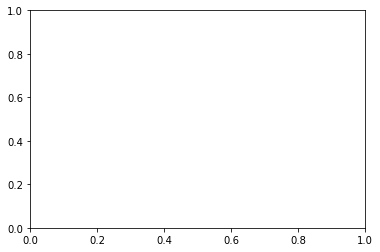

<Figure size 432x288 with 0 Axes>

In [86]:
welcome_title = "### This dashboard was developed to analyze existing portfolios and to provide." \
                " and gross rent in San Francisco, California from 2010 to 2016.  You can navigate through the tabs above to explore" \
                " more details about the evolution of the real estate market in The Golden City across these years."

welcome_tab = pn.pane.Markdown(welcome_title)

sector_tab = pn.Column(pn.Row(index_sector_plot(dow_jones_list, f'Dow Jones ({dow_jones_list.count()[0]} stocks / {dow_jones_marketcap})'),
                                    index_sector_plot(nasdaq_100_list, f'Nasdaq ({nasdaq_100_list.count()[0]} stocks / {nasdaq_100_marketcap})'),
                                    index_sector_plot(sp_500_list, f'S&P 500 ({sp_500_list.count()[0]} stocks / {sp_500_marketcap})')),                            
                             pn.Row(portfolio_sector_plot(df_jorge_holdings, f"Jorge's Portfolio ({len(jorge_holdings)} stocks / {jorge_total})"),
                                    portfolio_sector_plot(df_william_holdings, f"William's Portfolio ({len(william_holdings)} stocks / {william_total})"),
                                    portfolio_sector_plot(df_juancarlos_holdings, f"JC's Portfolio ({len(juancarlos_holdings)} stocks / {juancarlos_total})")))

rating_tab = pn.Column(pn.pane.Markdown("""
                                        ### Ratings
                                        |           |                        |           |                        |
                                        | ---:      | :---                   | ---:      | :---                   |
                                        | **DCF**   | - Discount Cash Flow   | **DE**    | - Debt-Equity          |
                                        | **ROE**   | - Return on Equity     | **PE**    | - Price-Earnings Ratio |
                                        | **ROA**   | - Return on Assets     | **PB**    | - Price-Book Ration    | 
                                        
                                        """),
                       pn.Tabs(('Jorge', pn.widgets.DataFrame(portfolio_ratings_plot(df_jorge_holdings),
                                                              show_index=False,
                                                              autosize_mode='fit_columns',
                                                              width=900)),
                               ('William', pn.widgets.DataFrame(portfolio_ratings_plot(df_william_holdings),
                                                                show_index=False,
                                                                autosize_mode='fit_columns',
                                                                width=900)),
                               ('JC', pn.widgets.DataFrame(portfolio_ratings_plot(df_juancarlos_holdings),
                                                                    show_index=False,
                                                                    autosize_mode='fit_columns',
                                                                    width=900))),
                       )

rebalance_text = "### Your Portfolio Investment Distribution at a glance" 

rebalance_tab = pn.Column(pn.Tabs(('Jorge', pn.Column(pn.pane.Markdown(rebalance_text),
                                                       portfolio_distribution_plot(df_jorge_holdings))),
                                   ('William', pn.Column(pn.pane.Markdown(rebalance_text), 
                                                         portfolio_distribution_plot(df_william_holdings))),
                                   ('JC', pn.Column(pn.pane.Markdown(rebalance_text), 
                                                    portfolio_distribution_plot(df_juancarlos_holdings)))))

screener_tab = pn.Column(pn.pane.Markdown("## Long Ideas"),
                         pn.widgets.DataFrame(long_ideas,show_index=False,autosize_mode='fit_columns'),
                         pn.pane.Markdown("## Short Ideas"),
                         pn.widgets.DataFrame(short_ideas,show_index=False,autosize_mode='fit_columns'))

portfolio_forecast_tab = pn.pane.Markdown(welcome_title)

bitcoin_forecast_tab = pn.Row(bitcoin_simulation_plot(),bitcoin_distribution_plot())



Column
    [0] Markdown(str, width=700)
    [1] Tabs
        [0] Markdown(str)
        [1] Column
            [0] Row
                [0] Plotly(Figure)
                [1] Plotly(Figure)
                [2] Plotly(Figure)
            [1] Row
                [0] Plotly(Figure)
                [1] Plotly(Figure)
                [2] Plotly(Figure)
        [2] Column
            [0] Tabs
                [0] Column
                    [0] Markdown(str)
                    [1] Matplotlib(Figure)
                [1] Column
                    [0] Markdown(str)
                    [1] Matplotlib(Figure)
                [2] Column
                    [0] Markdown(str)
                    [1] Matplotlib(Figure)
        [3] Column
            [0] Markdown(str)
            [1] Tabs
                [0] DataFrame(autosize_mode='fit_columns', show_index=False, value=              ..., width=900)
                [1] DataFrame(autosize_mode='fit_columns', show_index=False, value=                          ..., width=900)
                [2] DataFrame(autosize_mode='fit_columns', show_index=False, value=              ..., width=900)
        [4] Column
            [0] Markdown(str)
            [1] DataFrame(autosize_mode='fit_columns', show_index=False, value=   ticker     ...)
            [2] Markdown(str)
            [3] DataFrame(autosize_mode='fit_columns', show_index=False, value=  ticker      ...)
        [5] Markdown(str)
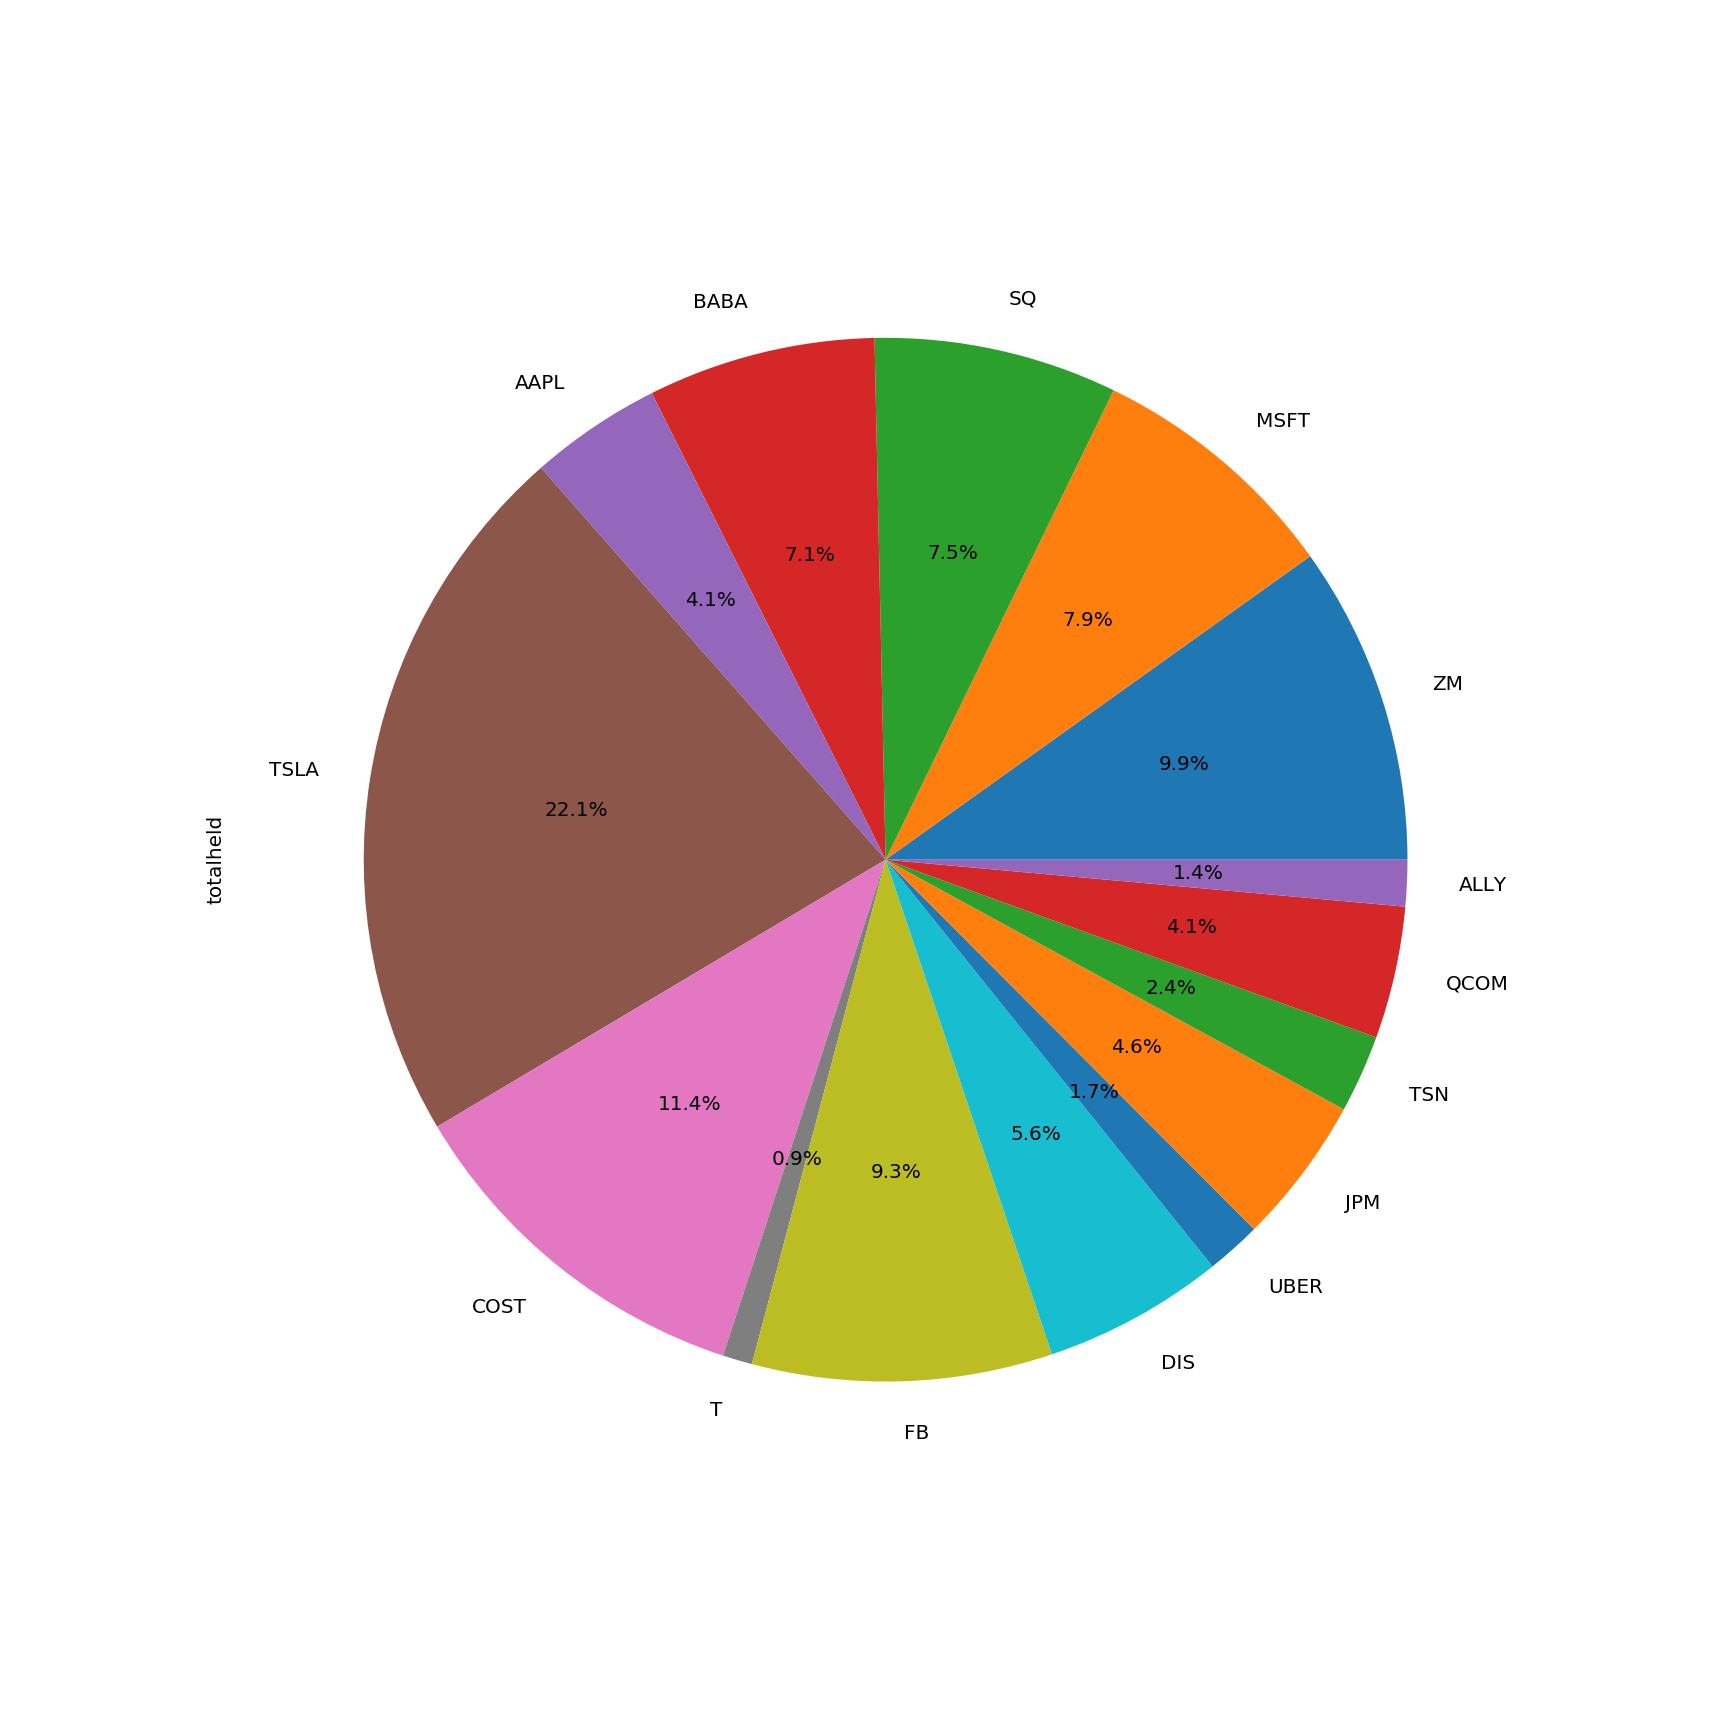
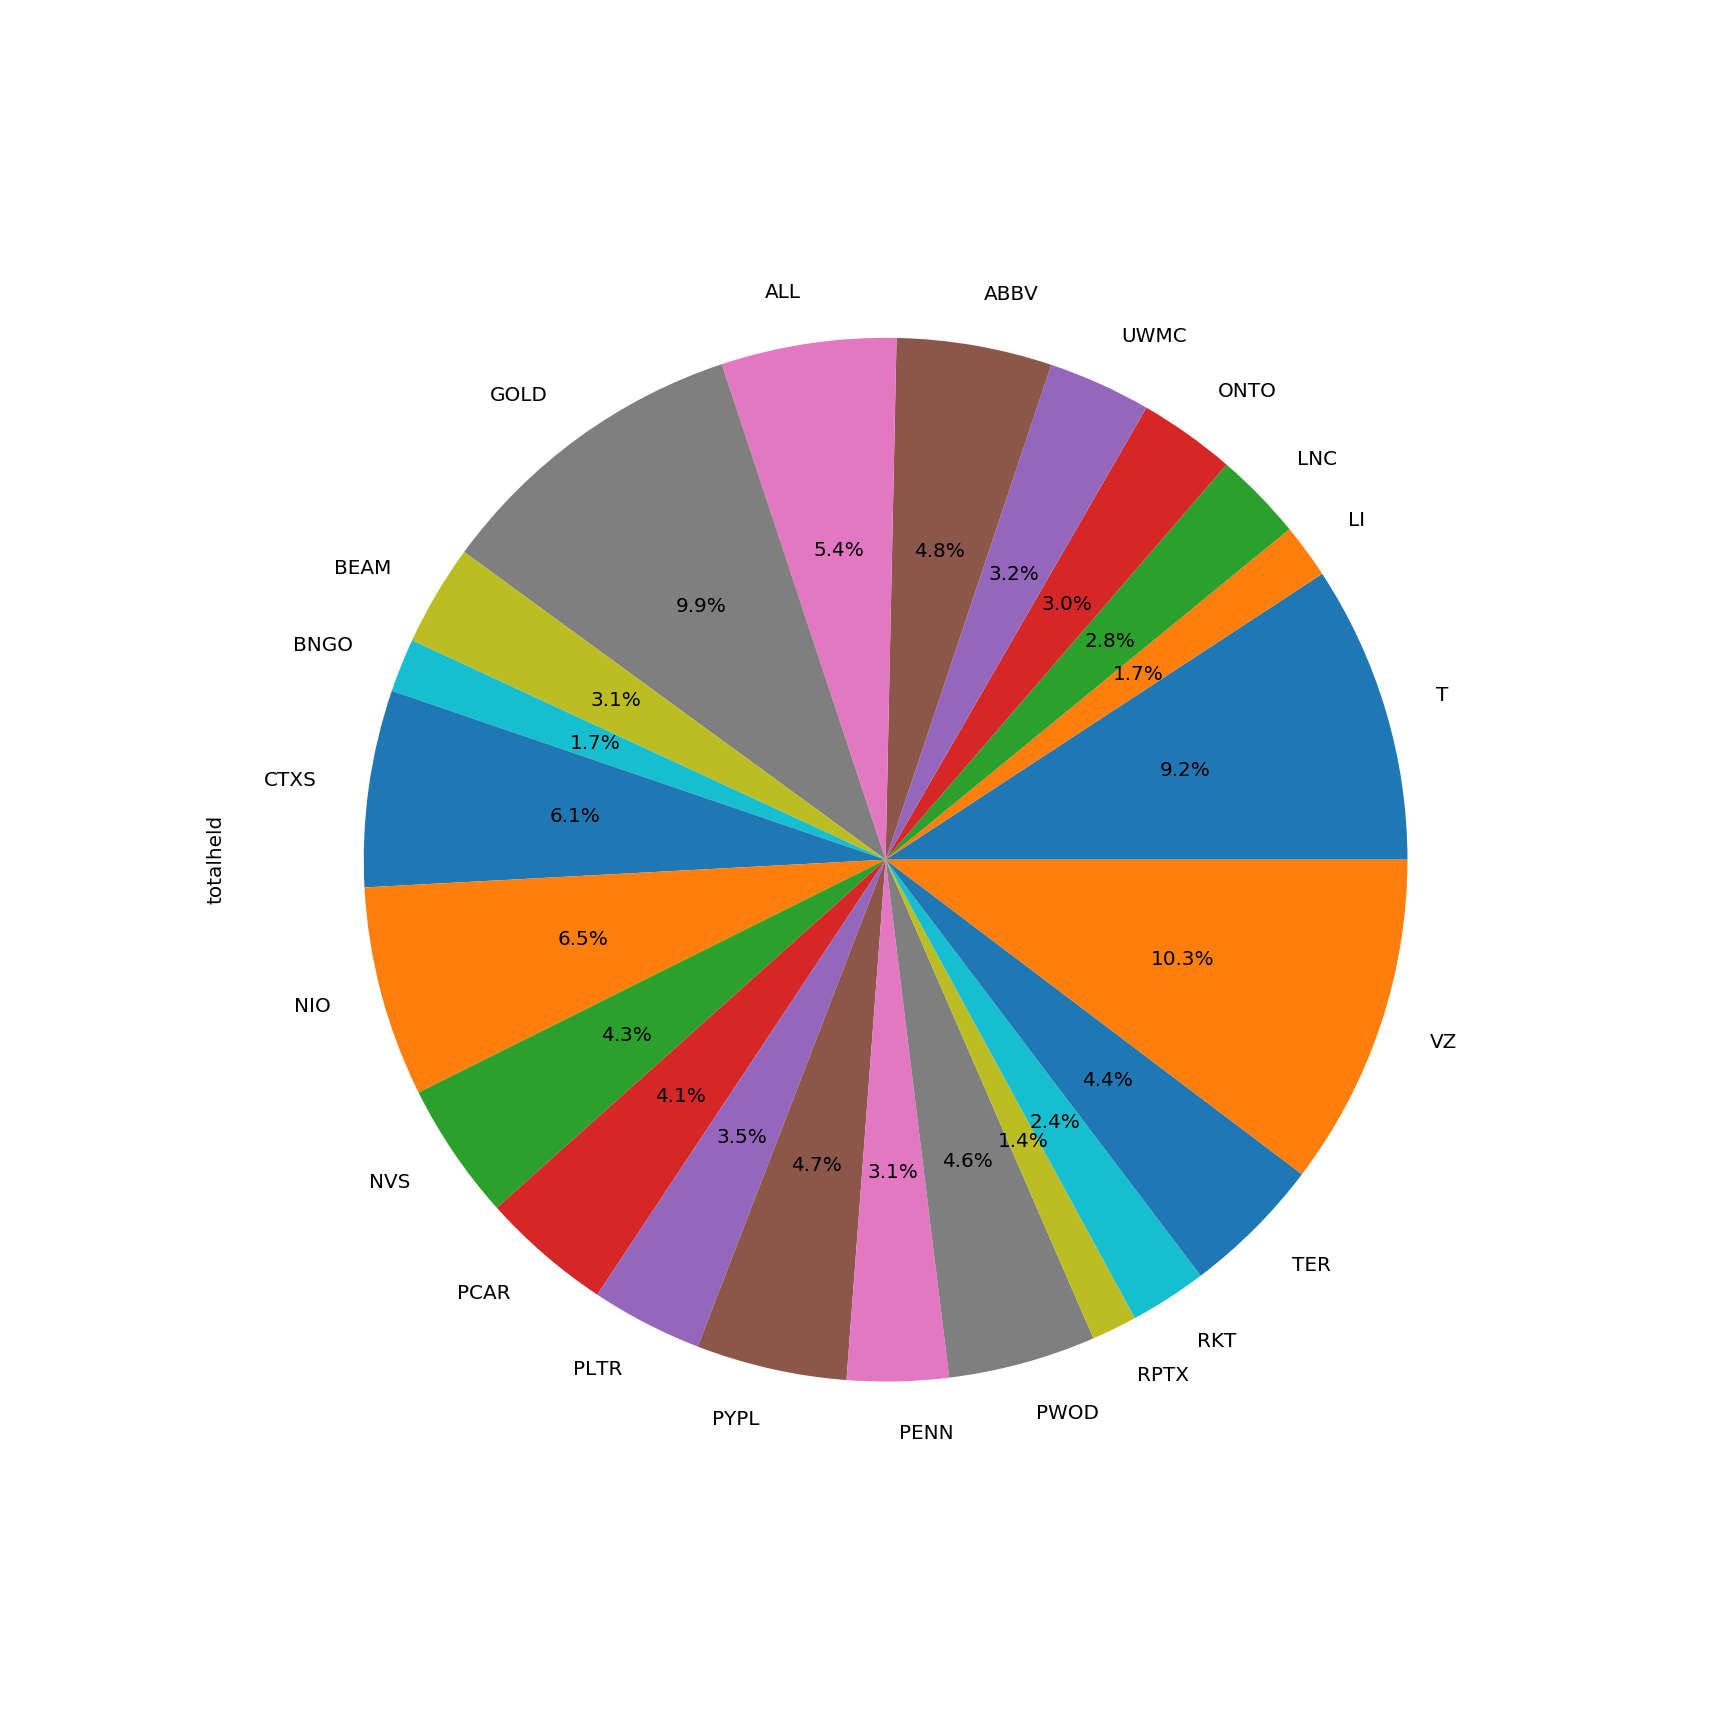
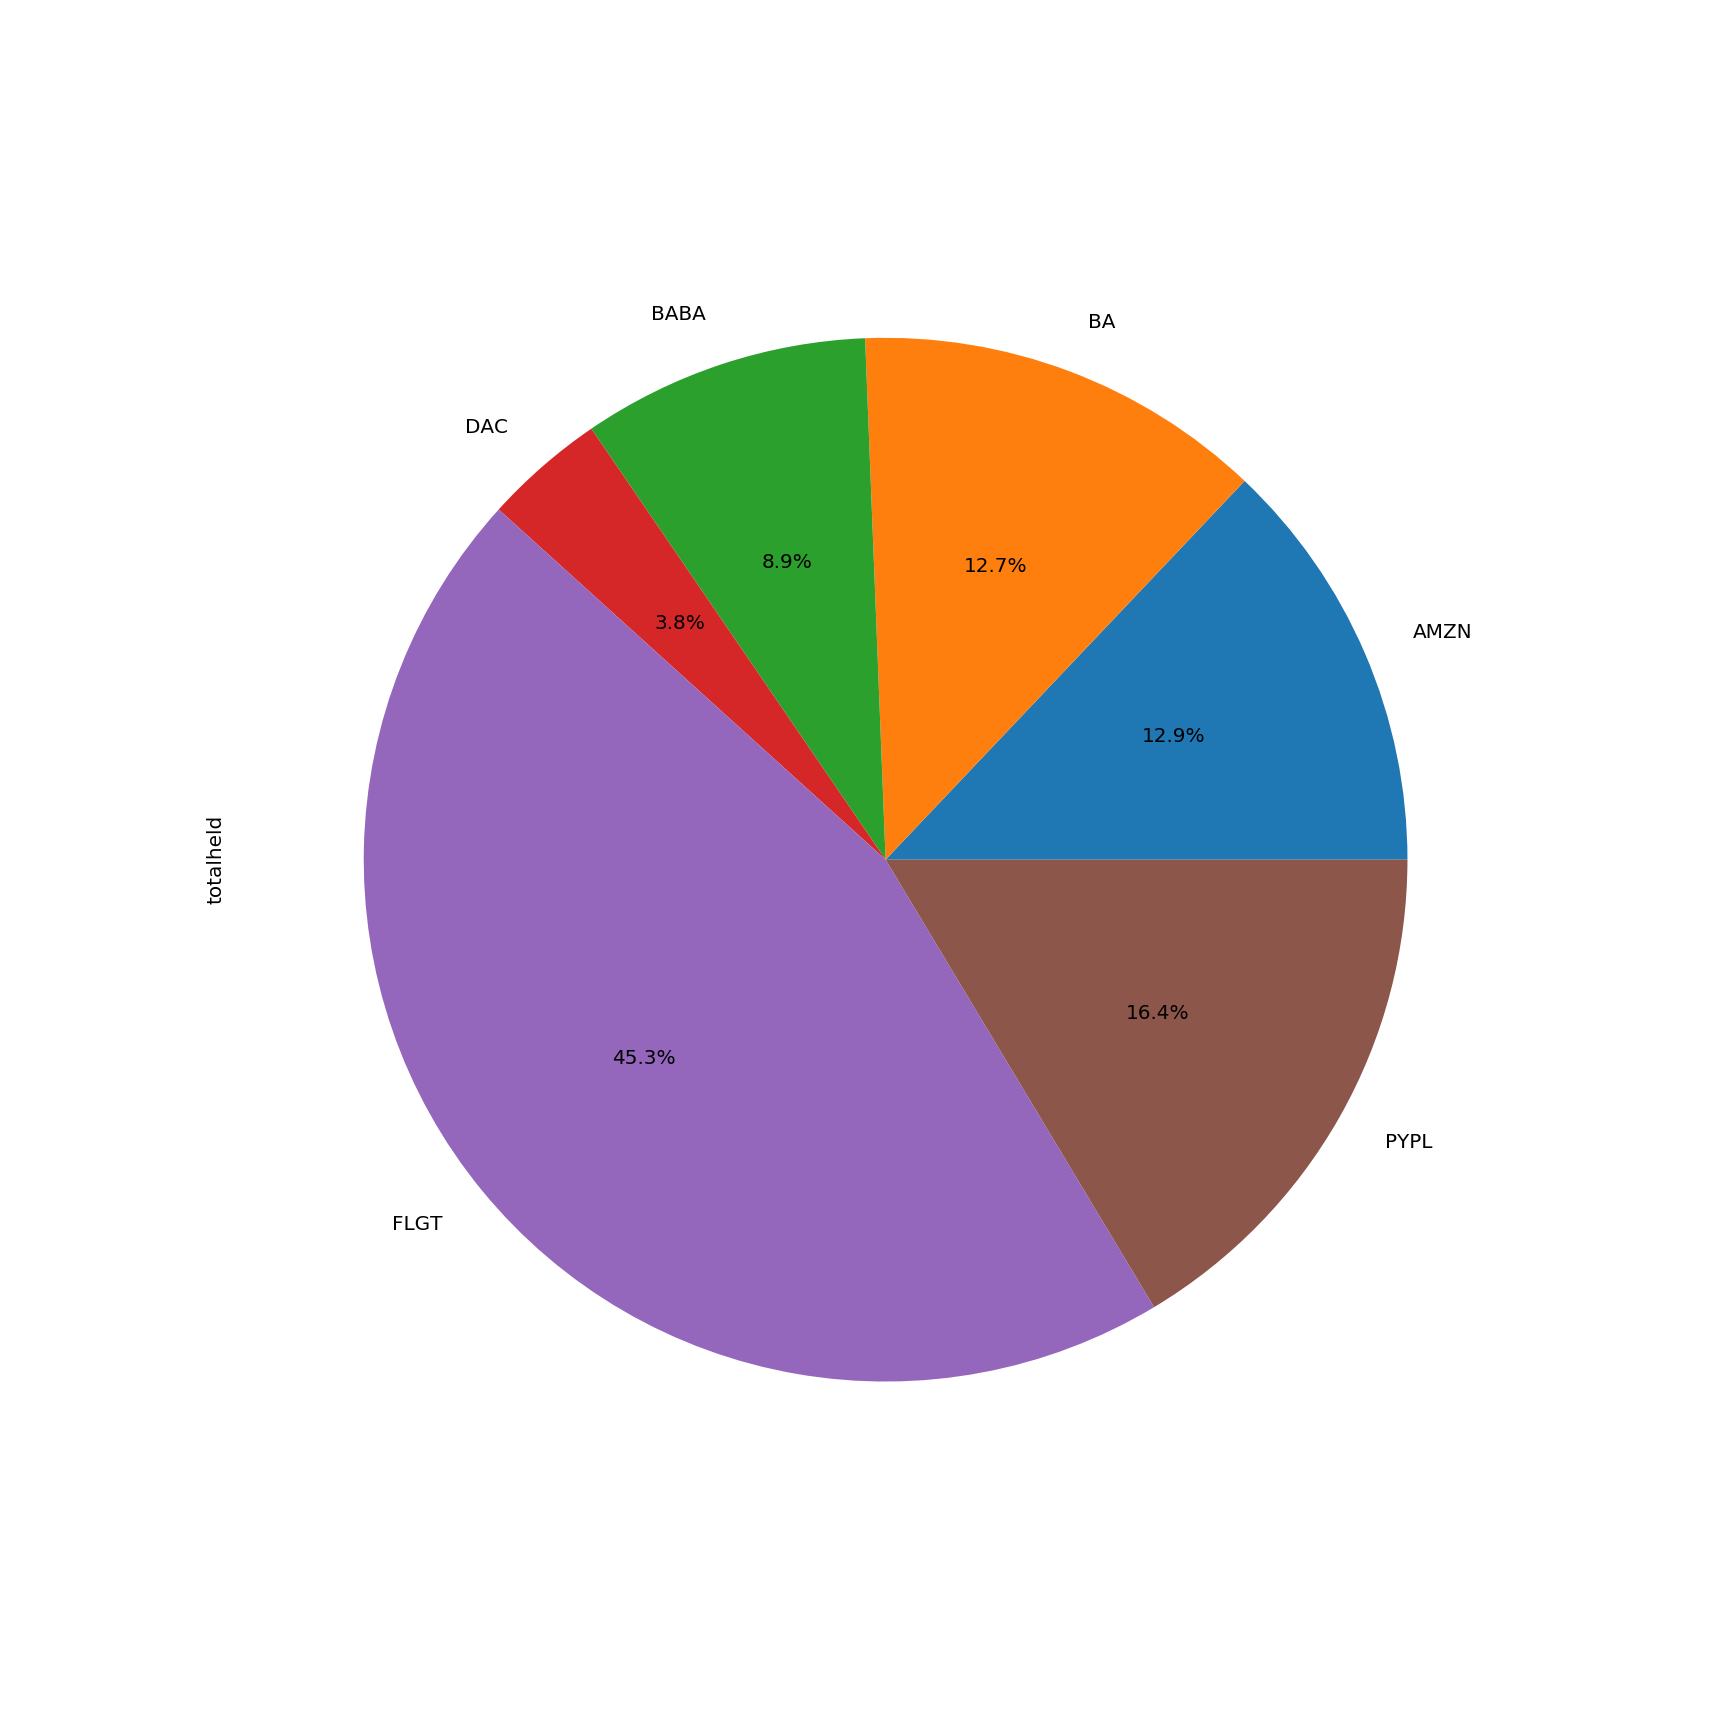

In [87]:
# Create a Title for the Dashboard
dashboard_title = '# Portfolio Analyzer'

# Create a tab layout for the dashboard
index_analysis_dashboard = pn.Column(pn.pane.Markdown(dashboard_title, width=700),pn.Tabs(('Welcome', welcome_tab),
                                                                                          ('Sector', sector_tab),
                                                                                          ('Rebalance', rebalance_tab),
                                                                                          ('Ratings', rating_tab),
                                                                                          ('Screener', screener_tab),
                                                                                          ('Portfolio Forecast', portfolio_forecast_tab)))
                                                                                          #('Bitcoin Forecast', bitcoin_forecast_tab)))                                                                        
                                                                                          
                                       
# Create the dashboard
index_analysis_dashboard.servable()

## Part 1 - Import Indicator data from Topfolio

In [22]:
# Import data from API into Dataframe

# Define Parameters
exchange = 'Binance'
symbol = 'BTCUSDT'
indicator_type = 'orderbook'
name = '0-1%'
interval = '3600'

# Create parameterized url
base_url = "https://api.topfol.io/indicators/candle?"
parameters_url = "startDate=2021-02-20&endDate=2021-04-20&exchange="+exchange+"&symbol="+symbol+"&indicator_type="+indicator_type+"&name="+name+"&interval="+interval
request_url = base_url + parameters_url

# Submit request and format output
response_data = requests.get(request_url)
pages = int(response_data.headers['page-amount'])

#Trouble shooting tool
#print (f'Number of Pages is {pages}')

new_results = True
page = 1
df_btcusdt_data = pd.DataFrame()

topfolio_api = requests.get(request_url).json()

data = topfolio_api

for page in range(2, pages+1):
    topfolio_api = requests.get(request_url + f"&page={page}").json()
    data.extend(topfolio_api)
    page += 1
    
df_btcusdt_data = json_normalize(data)


In [23]:
#Prepare Data for MCSimulation

# Convert Unix Time to iso format
df_btcusdt_data['timestamp']=(pd.to_datetime(df_btcusdt_data['timestamp'],unit='s')) 

# Set index to timestamp
df_btcusdt_data = df_btcusdt_data.set_index(['timestamp'])

# Sort Data
df_btcusdt_data = df_btcusdt_data.sort_index()

# Rename Column
df_btcusdt_data.columns = ['open','high','low','close']

df_btcusdt_data.columns = pd.MultiIndex.from_product([["BTCUSDT"], df_btcusdt_data.columns])

## Part 2 - Forecasting

### Monte Carlo Simulation

In [24]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
#Set number of simulations
num_sims = 1500

# Configure a Monte Carlo simulation to forecast
MC_72_hours = MCSimulation(
    portfolio_data = df_btcusdt_data,
    num_simulation = num_sims,
    num_trading_days = 72
)

In [25]:
# Running a Monte Carlo simulation to forecast a week cumulative returns
MC_72_hours.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011634,0.997957,1.007309,0.993395,0.987578,0.991576,0.998222,0.974017,1.007877,0.988495,...,0.994653,1.021932,0.994709,1.010787,1.002753,1.008072,1.011036,1.014229,1.009479,1.002086
2,1.004785,1.007627,1.005584,0.972188,0.992114,0.978799,1.004474,0.976324,1.001530,0.985327,...,0.999579,1.011032,0.982797,1.002725,1.003338,1.015291,1.015907,1.016596,1.019863,1.003427
3,1.006611,0.999194,1.020603,0.970726,1.011919,0.969514,1.014342,0.978413,0.992703,0.982581,...,1.022680,1.028183,0.985227,1.008483,1.014638,1.017439,1.020244,1.024388,1.023789,1.001442
4,0.996483,0.993548,1.011526,0.968364,1.005339,0.961127,1.020769,0.965214,0.991308,0.975416,...,1.022688,1.030836,0.976451,0.997687,1.013643,1.013114,1.016098,1.036021,1.017917,1.011326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.980808,0.982243,1.061742,0.904678,0.955791,0.876381,1.087854,0.894373,0.886417,0.991381,...,0.950781,0.959105,0.891713,0.881076,0.987319,1.130517,1.046636,1.085464,1.188420,1.215167
69,0.987553,0.974751,1.070571,0.909295,0.960437,0.875332,1.078147,0.895934,0.887668,0.990370,...,0.958504,0.956139,0.895543,0.871293,0.999792,1.128478,1.043023,1.095153,1.187214,1.196530
70,0.978640,0.960872,1.074549,0.906045,0.951772,0.876915,1.082721,0.891607,0.897107,0.993517,...,0.955913,0.958347,0.889953,0.872400,0.993236,1.116055,1.059474,1.107792,1.181856,1.197089
71,0.981129,0.973112,1.075593,0.903373,0.957487,0.871366,1.079264,0.893534,0.907360,0.992348,...,0.948024,0.955396,0.890426,0.865108,0.994359,1.140020,1.066757,1.124159,1.191483,1.199072


In [26]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_72_hours.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           1500.000000
mean               1.003503
std                0.075142
min                0.809210
25%                0.948850
50%                0.998997
75%                1.050685
max                1.263329
95% CI Lower       0.870128
95% CI Upper       1.164835
Name: 72, dtype: float64


In [102]:
# Get Bitcoin Price with Function
btc_price = get_btcusdt_price()

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*btc_price,0)
ci_upper = round(tbl[9]*btc_price,0)
diff_lower = round(btc_price - ci_lower,0)
diff_upper = round(ci_upper - btc_price,0)

# Print results
print(f"Bitcoin's current price is ${btc_price} and has a 95% chance that it will be" \
      f" within the range of ${ci_lower} and ${ci_upper}.")
print("over the next 72 hours")
print(f"Distance from upper is ${diff_upper}")
print(f"Distance from lower is ${diff_lower}")

Bitcoin's current price is $55452.0 and has a 95% chance that it will be within the range of $48250.0 and $64592.0.
over the next 72 hours
Distance from upper is $9140.0
Distance from lower is $7202.0


In [103]:
message = client.messages \
                .create(
                     body=(f"BTC ${btc_price} Predicted 72 hour range ${ci_lower} and ${ci_upper}"),
                     from_='+19032877979',
                     to='+13057257577'
                 )

print(message.sid)

SM1ace9e25672d4d7492d9a0cf22e2753c
